# EDA & Feature Engineering

First, we'll import all necessary libraries and set some basic variables that we'll reference throughout the notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Root path to datasets
PATH_TO_DATASETS = 'CICIDS2017/MachineLearningCVE'

### Data Preparation Checklist

<form action="">
  <label><input type="checkbox" id="dist_analysis" onclick="return false;"> Feature Distribution Analysis</label><br>
  <ul>
    <li><label><input type="checkbox" id="skew_kurt" onclick="return false;"> Analyze skewness and kurtosis of feature distributions</label></li>
    <li><label><input type="checkbox" id="outliers" onclick="return false;"> Identify and decide how to handle outliers</label></li>
  </ul>
  
  <label><input type="checkbox" id="feature_scaling" onclick="return false;"> Feature Scaling</label><br>
  <ul>
    <li><label><input type="checkbox" id="scaling_method" onclick="return false;"> Decide on scaling method</label></li>
    <li><label><input type="checkbox" id="apply_scaling" onclick="return false;"> Apply scaling to features</label></li>
  </ul>
  
  <label><input type="checkbox" id="feature_engineering" onclick="return false;"> Feature Engineering</label><br>
  <ul>
    <li><label><input type="checkbox" id="domain_features" onclick="return false;"> Create domain-specific features</label></li>
    <li><label><input type="checkbox" id="interaction_terms" onclick="return false;"> Explore and create interaction terms for linear models</label></li>
    <li><label><input type="checkbox" id="dimension_reduction" onclick="return false;"> Consider dimensionality reduction (PCA)</label></li>
  </ul>
  
  <label><input type="checkbox" id="class_imbalance" onclick="return false;"> Class Imbalance</label><br>
  <ul>
    <li><label><input type="checkbox" id="evaluate_balance" onclick="return false;"> Evaluate balance of target variable</label></li>
    <li><label><input type="checkbox" id="address_imbalance" onclick="return false;"> Apply strategies to address imbalance</label></li>
  </ul>
  
  <label><input type="checkbox" id="temporal_features" onclick="return false;"> Temporal Features</label><br>
  <ul>
    <li><label><input type="checkbox" id="create_temporal" onclick="return false;"> Create features from temporal information</label></li>
  </ul>
  
  <label><input type="checkbox" id="data_visualization" onclick="return false;"> Data Visualization</label><br>
  <ul>
    <li><label><input type="checkbox" id="use_plots" onclick="return false;"> Use plots to visualize data and relationships</label></li>
  </ul>
  
  <label><input type="checkbox" id="final_cleaning" onclick="return false;"> Final Data Cleaning</label><br>
  <ul>
    <li><label><input type="checkbox" id="data_cleaning_steps" onclick="return false;"> Ensure all cleaning steps have been performed</label></li>
  </ul>
  
  <label><input type="checkbox" id="final_review" onclick="return false;"> Final Review</label><br>
  <ul>
    <li><label><input type="checkbox" id="dataset_readiness" onclick="return false;"> Perform a final review of dataset readiness for modeling</label></li>
  </ul>
</form>

## Merge Datasets

Next, we'll concatenated all of the dataframes. Currently, the datsets are partitioned by day. Thursday and Friday are further partitioned in two and three files, respectively.

We'll start with a rudimentary approach where we initialize a dataframe for each CSV file and store the dataframe in a hashmap.

In [3]:
# Load the datasets
monday_data = pd.read_csv(f'{PATH_TO_DATASETS}/Monday-WorkingHours.pcap_ISCX.csv')
tuesday_data = pd.read_csv(f'{PATH_TO_DATASETS}/Tuesday-WorkingHours.pcap_ISCX.csv')
wednesday_data = pd.read_csv(f'{PATH_TO_DATASETS}/Wednesday-workingHours.pcap_ISCX.csv')
thursday_morning_webattacks_data = pd.read_csv(f'{PATH_TO_DATASETS}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
thursday_afternoon_infiltration_data = pd.read_csv(f'{PATH_TO_DATASETS}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
friday_morning_data = pd.read_csv(f'{PATH_TO_DATASETS}/Friday-WorkingHours-Morning.pcap_ISCX.csv')
friday_afternoon_portscan_data = pd.read_csv(f'{PATH_TO_DATASETS}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
friday_afternoon_ddos_data = pd.read_csv(f'{PATH_TO_DATASETS}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# Paths to dataset files
dataset_paths = [
    f'{PATH_TO_DATASETS}/Monday-WorkingHours.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Tuesday-WorkingHours.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Wednesday-workingHours.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    f'{PATH_TO_DATASETS}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
]

# Create a summary of each dataset to understand the initial structure
datasets = {
    'Monday': monday_data,
    'Tuesday': tuesday_data,
    'Wednesday': wednesday_data,
    'Thursday Morning Web Attacks': thursday_morning_webattacks_data,
    'Thursday Afternoon Infiltration': thursday_afternoon_infiltration_data,
    'Friday Morning': friday_morning_data,
    'Friday Afternoon PortScan': friday_afternoon_portscan_data,
    'Friday Afternoon DDoS': friday_afternoon_ddos_data
}

Merging them will allow us to interface with the data more easily. However, we'll preserve the source file as a new feature in case it's valuable later.

More than likely, we'll end up dropping this feature because we don't want the algorithm to be biased towards time. Time (e.g., day of the week) is not inherently predictive of whether a network packet is malicious or not.

In [3]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files in the specified directory
for filename in os.listdir(PATH_TO_DATASETS):
    if filename.endswith('.pcap_ISCX.csv'):
        # Construct the full file path
        file_path = os.path.join(PATH_TO_DATASETS, filename)
        
        # Load the dataset
        data = pd.read_csv(file_path)
        
        # Sanitize the file name to use as the 'Source File' value
        # Remove hyphens, the file extension, and other unnecessary parts of the filename
        sanitized_name = filename.replace('-', ' ').replace('.pcap_ISCX.csv', '').title()
        
        # Add the 'Source File' column with the sanitized name
        data['Source File'] = sanitized_name
        
        # Append the DataFrame to our list
        dataframes.append(data)

# Concatenate all DataFrames in the list
all_data = pd.concat(dataframes, ignore_index=True)

In [4]:
all_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Source File
0,22,166,1,1,0,0,0,0,0.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,Thursday Workinghours Afternoon Infilteration
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,Thursday Workinghours Afternoon Infilteration
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,Thursday Workinghours Afternoon Infilteration
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,Thursday Workinghours Afternoon Infilteration
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN,Thursday Workinghours Afternoon Infilteration


In [5]:
# Display the shape of the concatenated dataset
print(f'There are {all_data.shape[0]} samples with {all_data.shape[1]} features.')

There are 2830743 samples with 80 features.


## Features

Next, let's explore what kind of features we're dealing with. i.e., Are they numeric or string values? Are there any null/missing values?

In [6]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

It looks like some of the feature/column names may have whitespaces in them.

Let's sanitize the feature names by stripping whitespace and potentially replacing spaces between words with underscores to ensure consistency. 

In [7]:
# Sanitize feature names by removing leading/trailing whitespace and replacing spaces with underscores
all_data.columns = all_data.columns.str.strip().str.replace(' ', '_').str.replace('-', '_').str.lower()

# Now let's check the columns to ensure they've been renamed as expected
print(all_data.columns)

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

## Null Values

This approach checks each column for the presence of any null values and returns a boolean indicating whether each column contains at least one null value.

In [8]:
# Check for any null values in each column
null_columns = all_data.isnull().any()

# Print columns with null values
print("Columns with null values:")
print(null_columns[null_columns == True])

Columns with null values:
flow_bytes/s    True
dtype: bool


This will give us a clearer picture of how many null values are present in each column, allowing us to decide how to handle these missing values effectively, whether by imputation, dropping the rows or columns, or some other method.

In [9]:
# Count of null values in each column
null_counts = all_data.isnull().sum()

# Print columns with their count of null values, but only those that have nulls
print("Count of null values in columns with nulls:")
print(null_counts[null_counts > 0])

Count of null values in columns with nulls:
flow_bytes/s    1358
dtype: int64


The **Flow Bytes/s** feature represents the rate at which bytes are transmitted over a network during a specific flow. A flow is as a sequence of packets sent from a source to a destination, characterized by attributes like IP addresses, port numbers, and protocol.

 Null or missing values in Flow Bytes/s could occur for various legitimate reasons. For instance, if a flow's duration is extremely short (possibly even zero), calculating a rate might result in undefined or infinite values, which could be represented as nulls. Alternatively, if there were no packet transmissions during a specific interval, this might also result in a null value for the flow rate.

 Before deciding on how to handle these null values, it might be worth investigating them in the context of other features. For example, checking the **Flow Duration** for these records might offer insights: flows with very short durations might explain the nulls.

In [10]:
# Filter the dataset to include only rows where 'Flow Bytes/s' is null
null_flow_bytes = all_data[all_data['flow_bytes/s'].isnull()]

# Examine 'Flow Duration' for these samples
print(null_flow_bytes['flow_duration'].describe())

# Examine packet counts for samples with null 'Flow Bytes/s'
print(null_flow_bytes[['total_fwd_packets', 'total_backward_packets']].describe())

count    1358.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: flow_duration, dtype: float64
       total_fwd_packets  total_backward_packets
count        1358.000000             1358.000000
mean            1.854934                0.145803
std             0.352297                0.353038
min             1.000000                0.000000
25%             2.000000                0.000000
50%             2.000000                0.000000
75%             2.000000                0.000000
max             2.000000                1.000000


All samples with null flow_bytes/s have a flow_duration of 0. This suggests that these flows are instantaneous and do not last any measurable amount of time. In the context of network traffic, a flow_duration of 0 could mean that the flow was initiated and terminated within the same timestamp unit used for measurement, thus not allowing for a rate (flow_bytes/s) to be calculated.

The total_fwd_packets and total_backward_packets statistics show that, on average, there are about 1-2 forward packets and very few (if any) backward packets. This suggests minimal to no response or acknowledgment packets in these flows, which aligns with the instantaneous nature of these flows.

Given this context, the null flow_bytes/s values *appear* to be a natural consequence of the flow_duration being 0, rather than missing data due to recording errors. Therefore, simply imputing these nulls with a mean or median could introduce bias or inaccuracies. Since these flows are instantaneous and have no duration, it might make sense to set flow_bytes/s for these records to 0. This directly reflects the fact that, over the zero duration, no bytes were transmitted per second.

We'll need to review the literature before making a final determination.

## Feature Correlation

Let's start by encoding the 'label' feature as it needs to be numerical in order to compute a confusion matrix.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the 'label' column and transform it to numerical codes
all_data['label_encoded'] = label_encoder.fit_transform(all_data['label'])

# Verify the transformation
print(all_data[['label', 'label_encoded']].head())

    label  label_encoded
0  BENIGN              0
1  BENIGN              0
2  BENIGN              0
3  BENIGN              0
4  BENIGN              0


We'll create a label mapping to ensure we can flip back and forth between the encoded and decoded values.

This approach ensures the labels are correctly encoded for model training and analyses and provides an easy path to revert to the original categorical labels for interpretability.

In [12]:
# Store the mapping from encoded labels to original labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# To easily decode later, also store the inverse mapping
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

print("Label Mapping to Encoded Values:", label_mapping)
print("Inverse Mapping for Decoding:", inverse_label_mapping)

Label Mapping to Encoded Values: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}
Inverse Mapping for Decoding: {0: 'BENIGN', 1: 'Bot', 2: 'DDoS', 3: 'DoS GoldenEye', 4: 'DoS Hulk', 5: 'DoS Slowhttptest', 6: 'DoS slowloris', 7: 'FTP-Patator', 8: 'Heartbleed', 9: 'Infiltration', 10: 'PortScan', 11: 'SSH-Patator', 12: 'Web Attack � Brute Force', 13: 'Web Attack � Sql Injection', 14: 'Web Attack � XSS'}


In [13]:
# Create a new DataFrame excluding the 'label' column
numeric_data = all_data.drop(columns=['label', 'source_file'])

# Compute the correlation matrix on numeric data only
correlation_matrix = numeric_data.corr()

# Continue with your correlation analysis as before
correlation_threshold = 0.9
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Print correlated features to consider removing
print(correlated_features)

{'subflow_bwd_packets', 'bwd_packet_length_mean', 'fwd_iat_mean', 'idle_mean', 'avg_bwd_segment_size', 'bwd_packet_length_std', 'fwd_iat_max', 'avg_fwd_segment_size', 'packet_length_mean', 'ece_flag_count', 'subflow_bwd_bytes', 'packet_length_variance', 'subflow_fwd_packets', 'idle_min', 'active_min', 'fwd_packet_length_std', 'fwd_iat_std', 'total_length_of_bwd_packets', 'fwd_header_length.1', 'fwd_iat_total', 'flow_iat_max', 'average_packet_size', 'cwe_flag_count', 'fwd_packets/s', 'total_backward_packets', 'subflow_fwd_bytes', 'max_packet_length', 'idle_max', 'bwd_iat_min', 'packet_length_std', 'syn_flag_count'}


In [34]:
correlated_features

{'active_min',
 'average_packet_size',
 'avg_bwd_segment_size',
 'avg_fwd_segment_size',
 'bwd_iat_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'cwe_flag_count',
 'ece_flag_count',
 'flow_iat_max',
 'fwd_header_length.1',
 'fwd_iat_max',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_total',
 'fwd_packet_length_std',
 'fwd_packets/s',
 'idle_max',
 'idle_mean',
 'idle_min',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'subflow_bwd_bytes',
 'subflow_bwd_packets',
 'subflow_fwd_bytes',
 'subflow_fwd_packets',
 'syn_flag_count',
 'total_backward_packets',
 'total_length_of_bwd_packets'}

In [31]:
len(correlated_features)

31

In [14]:
corr_matrix = numeric_data.corr()
corr_matrix

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label_encoded
destination_port,1.000000,-0.151680,-0.004236,-0.003947,0.011145,-0.003082,0.097926,-0.045388,0.140220,0.128861,...,0.000897,-0.035562,-0.043717,-0.051859,-0.023194,-0.112585,0.010399,-0.108185,-0.114614,-0.078526
flow_duration,-0.151680,1.000000,0.020857,0.019670,0.065456,0.016186,0.273308,-0.105230,0.143689,0.234437,...,-0.001357,0.189299,0.241060,0.294034,0.121171,0.768034,0.243154,0.779527,0.738328,0.072592
total_fwd_packets,-0.004236,0.020857,1.000000,0.999070,0.365508,0.996993,0.009358,-0.002989,0.000032,0.001403,...,-0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670,-0.003324
total_backward_packets,-0.003947,0.019670,0.999070,1.000000,0.359451,0.994429,0.009039,-0.002600,-0.000333,0.001026,...,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330,-0.003122
total_length_of_fwd_packets,0.011145,0.065456,0.365508,0.359451,1.000000,0.353762,0.197030,-0.000275,0.185262,0.159787,...,-0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634,-0.014874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
idle_mean,-0.112585,0.768034,0.001820,0.001425,0.022660,0.000809,0.181135,-0.071304,0.127959,0.183139,...,-0.000876,0.120171,0.036551,0.088904,0.118133,1.000000,0.150248,0.990387,0.990215,0.187675
idle_std,0.010399,0.243154,0.000809,0.000492,0.027064,0.000105,0.178091,-0.029951,0.178462,0.191278,...,-0.003720,0.070586,0.081435,0.070002,0.038302,0.150248,1.000000,0.283330,0.011609,0.023257
idle_max,-0.108185,0.779527,0.001906,0.001456,0.026079,0.000797,0.199559,-0.073419,0.148402,0.203304,...,-0.001407,0.132700,0.055300,0.102816,0.122651,0.990387,0.283330,1.000000,0.961812,0.186252
idle_min,-0.114614,0.738328,0.001670,0.001330,0.018634,0.000789,0.156973,-0.067435,0.104155,0.157677,...,-0.000344,0.109878,0.023540,0.077261,0.112880,0.990215,0.011609,0.961812,1.000000,0.187095


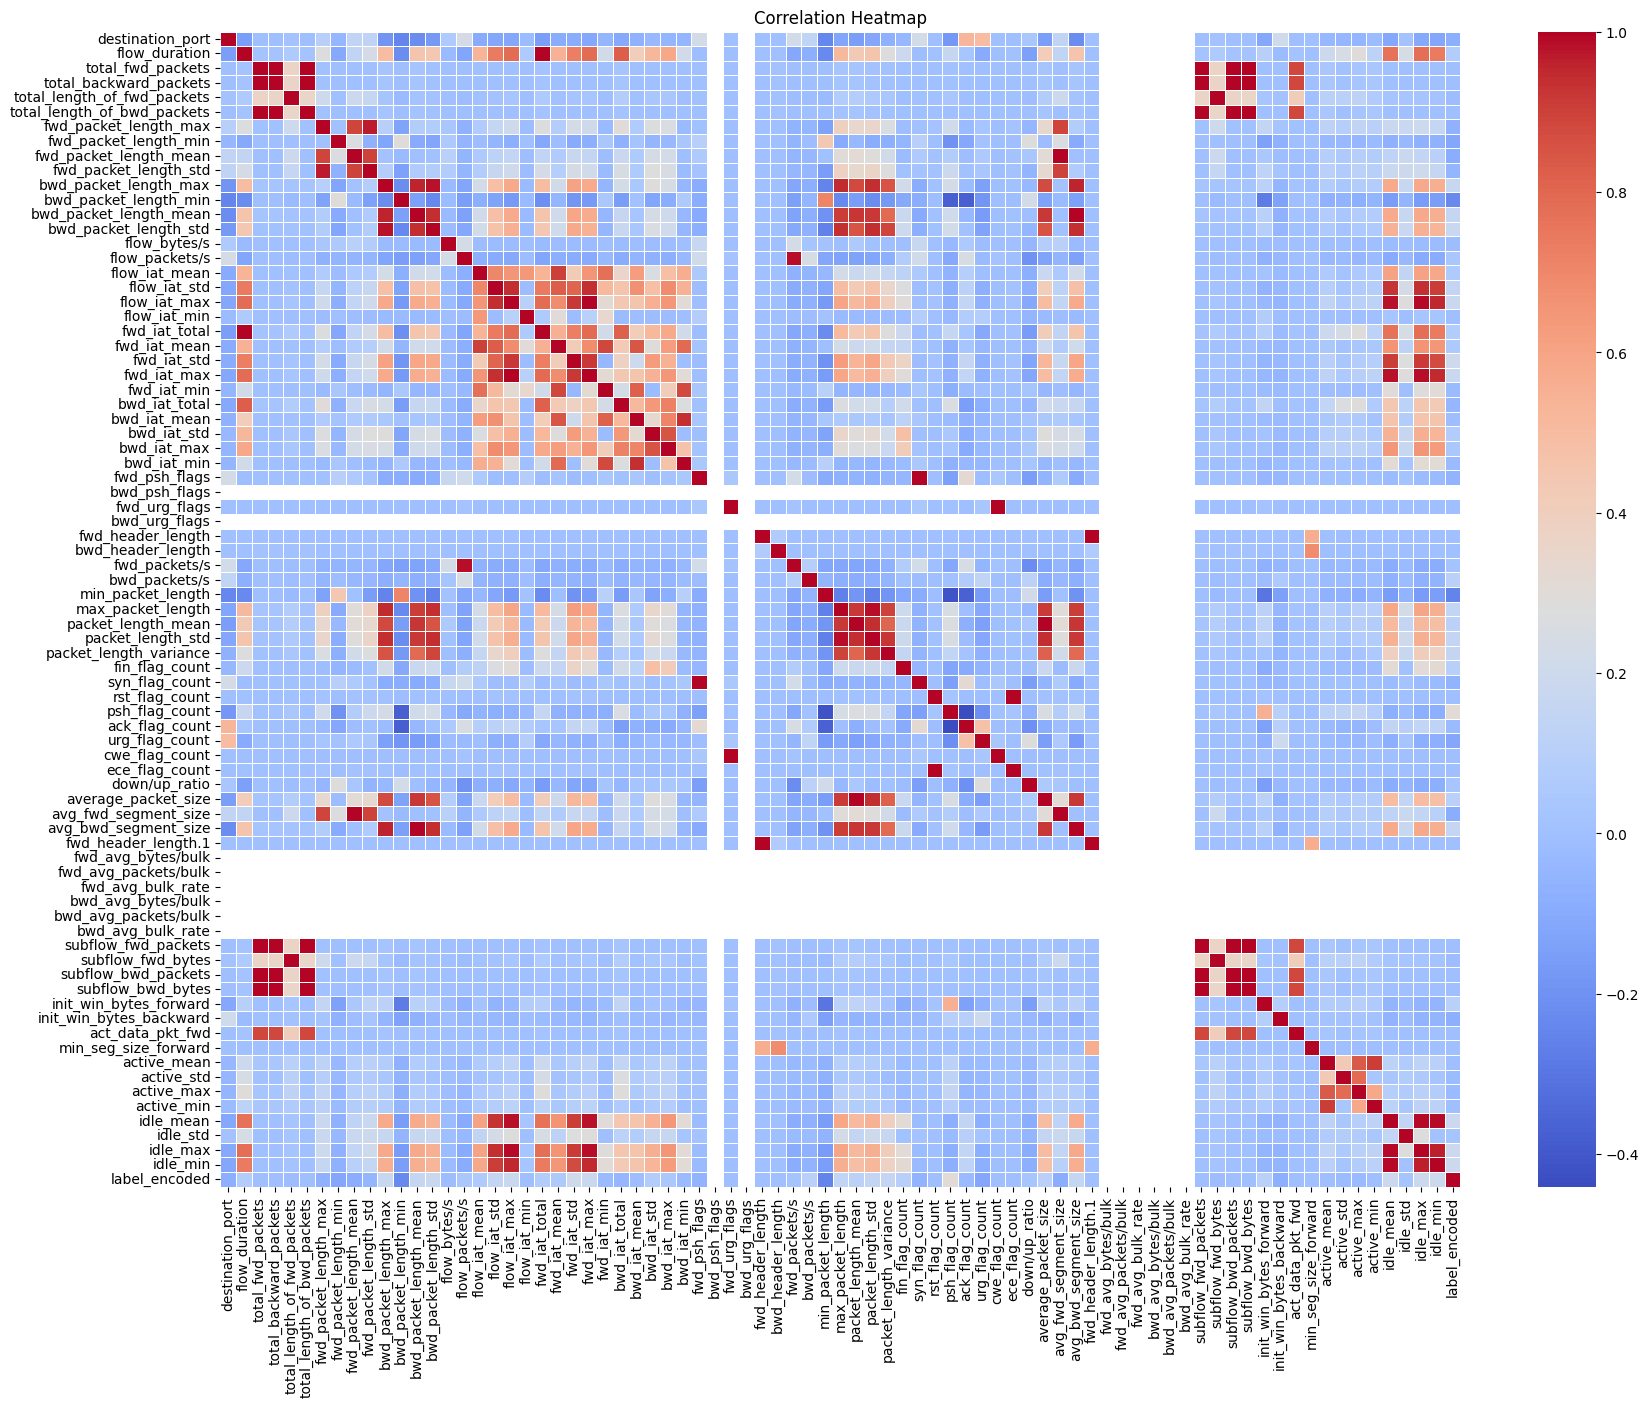

In [15]:
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
# Remove the identified highly correlated features
reduced_multicol_numeric_data = numeric_data.drop(columns=list(correlated_features))

# Review the shape of the data after removal to confirm the changes
print("Shape of the dataset after removing highly correlated features:", reduced_multicol_numeric_data.shape)

Shape of the dataset after removing highly correlated features: (2830743, 48)


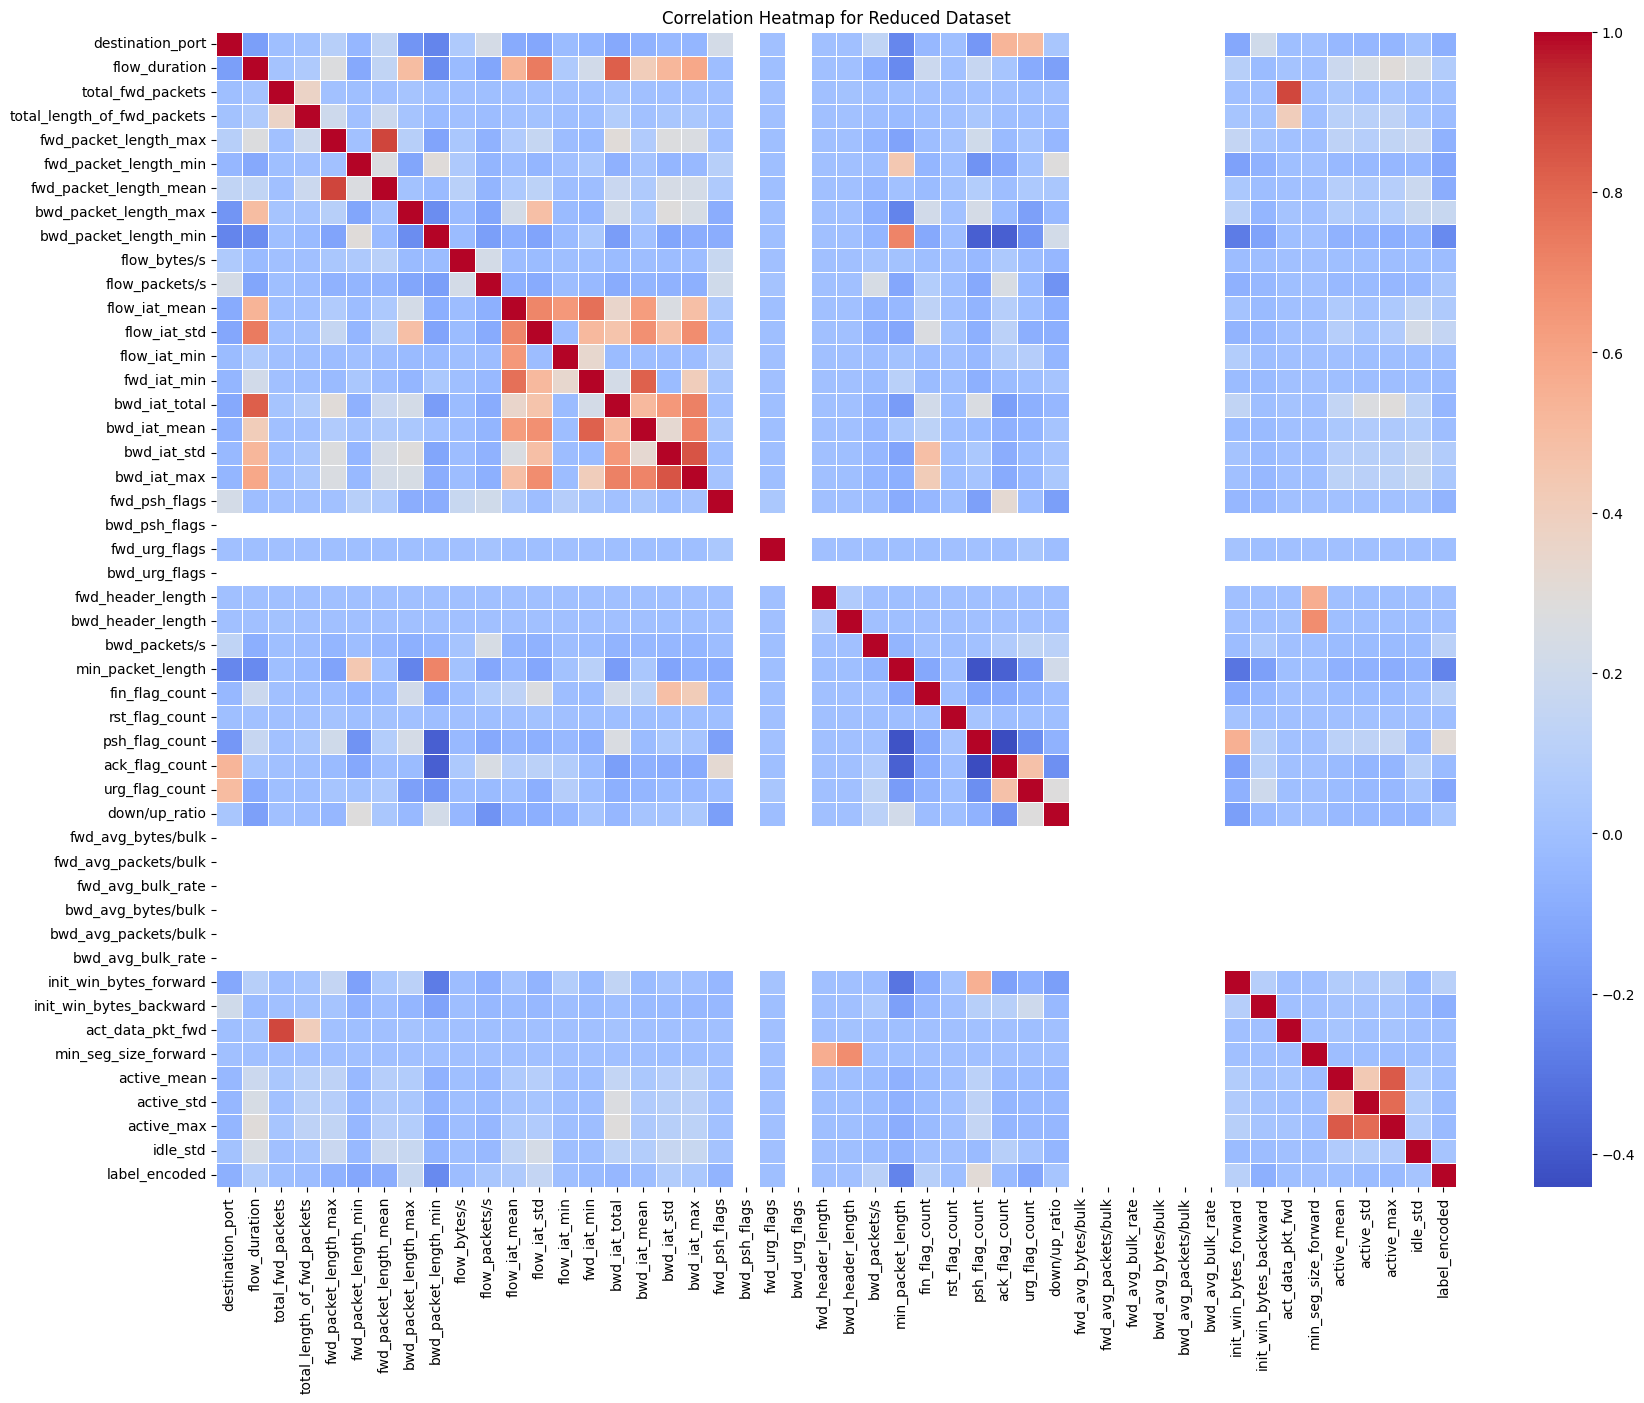

In [17]:
reduced_corr_matrix = reduced_multicol_numeric_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(reduced_corr_matrix, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Correlation Heatmap for Reduced Dataset')
plt.show()

## Feature Skewness

Next, we'll explore how much variance are in the features by printing out all de-duplicated (unique) values for each feature, up to the first 20 values.

In [56]:
# Analyze skewness
feature_skewness = reduced_multicol_numeric_data.skew()
print("Feature Skewness:\n", feature_skewness)

# Analyze kurtosis
feature_kurtosis = reduced_multicol_numeric_data.kurtosis()
print("\nFeature Kurtosis:\n", feature_kurtosis)

# Identifying outliers can be done using IQR (Interquartile Range) method or visual methods like box plots
# Here's an example of how to calculate IQR for a feature
q1 = reduced_multicol_numeric_data['flow_duration'].quantile(0.25)
q3 = reduced_multicol_numeric_data['flow_duration'].quantile(0.75)
iqr = q3 - q1
outlier_threshold_high = q3 + 1.5 * iqr
outlier_threshold_low = q1 - 1.5 * iqr
print("\nFlow Duration Outliers Above:", reduced_multicol_numeric_data[reduced_multicol_numeric_data['flow_duration'] > outlier_threshold_high].shape[0])
print("Flow Duration Outliers Below:", reduced_multicol_numeric_data[reduced_multicol_numeric_data['flow_duration'] < outlier_threshold_low].shape[0])

/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


Feature Skewness:
 destination_port                  2.072052
flow_duration                     2.155356
total_fwd_packets               244.380553
total_length_of_fwd_packets     805.570539
fwd_packet_length_max             9.849179
fwd_packet_length_min            20.139172
fwd_packet_length_mean            9.135766
bwd_packet_length_max             2.938355
bwd_packet_length_min             4.838119
flow_bytes/s                           NaN
flow_packets/s                         NaN
flow_iat_mean                     8.969789
flow_iat_std                      3.611056
flow_iat_min                     23.788151
fwd_iat_min                       9.712721
bwd_iat_total                     2.884194
bwd_iat_mean                      8.250627
bwd_iat_std                       5.792927
bwd_iat_max                       4.435718
fwd_psh_flags                     4.310324
bwd_psh_flags                     0.000000
fwd_urg_flags                    94.781303
bwd_urg_flags                     0

/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1344: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean



Feature Kurtosis:
 destination_port               2.518182e+00
flow_duration                  3.020273e+00
total_fwd_packets              6.175443e+04
total_length_of_fwd_packets    9.885526e+05
fwd_packet_length_max          1.367458e+02
fwd_packet_length_min          4.765584e+02
fwd_packet_length_mean         9.493513e+01
bwd_packet_length_max          8.912238e+00
bwd_packet_length_min          7.299276e+01
flow_bytes/s                            NaN
flow_packets/s                          NaN
flow_iat_mean                  1.230515e+02
flow_iat_std                   1.497700e+01
flow_iat_min                   6.240694e+02
fwd_iat_min                    1.003753e+02
bwd_iat_total                  6.814527e+00
bwd_iat_mean                   7.854850e+01
bwd_iat_std                    3.710887e+01
bwd_iat_max                    1.942198e+01
fwd_psh_flags                  1.657890e+01
bwd_psh_flags                  0.000000e+00
fwd_urg_flags                  8.981502e+03
bwd_urg_flag

# Literature Review

The dataset does not provide a flow_id to indicate groupings of packets. We will have to glean this information ourselves.

Let's visit the literature behind the dataset.

> The following table (Table 3) shows the list of the best selected features and corresponding weight of each section. 
> 
> As Table 3 shows, the Flow Inter arrival time (IAT) related features such as Min, Mean, Max and also the Flow Duration are the best common features for DoS detection. 
> 
> For the Heartbleed attack, the Flow Duration, Subflow Forwarding (Fwd) and Backwarding (Bwd) bytes alongwith packet length features such as Standard Deviation (Std) of the backward packets and length of forward packets are most influential features. SSH-Patator and FTP-Patator as representations of the brute force attack, shown that Initial window bytes along with some flags such as Acknowledge (ACK), Push (Psh) and Synchronization (SYN) are the most useful features for tracing this attack. 
> 
> Besides, the analysis shows that for detecting the Web attacks, Initial Window Bytes (Forwarding and Backwarding), forwarding subflow bytes and forwarding packet’s length are the best features. While for discovering the infiltration attack, forwarding subflow bytes and forwarding packets’ length along with the duration of the flow and Mean of active time is important. 
> 
> Again forwarding subflow bytes and forwarding packet’s length and mean with backward packets are the best features for Bot detection also. Initial forwarding window bytes, backward packets and push flags are the best presented feature set. 
> 
> Finally, for DDoS attack, backward packet length, average packet size and some inter arrival time related features have been selected.

TABLE 3: Feature Selection

|Label        |Feature            |Weight|
|-------------|-------------------|------|
|Benign       |B.Packet Len Min   |0.0479|
|Benign       |Subflow F.Bytes    |0.0007|
|Benign       |Total Len F.Packets|0.0004|
|Benign       |F.Packet Len Mean  |0.0002|
|DoS GoldenEye|B.Packet Len Std   |0.1585|
|DoS GoldenEye|Flow IAT Min       |0.0317|
|DoS GoldenEye|Fwd IAT Min        |0.0257|
|DoS GoldenEye|Flow IAT Mean      |0.0214|
|Heartbleed   |B.Packet Len Std   |0.2028|
|Heartbleed   |Subflow F.Bytes    |0.1367|
|Heartbleed   |Flow Duration      |0.0991|
|Heartbleed   |Total Len F.Packets|0.0903|
|DoS Hulk     |B.Packet Len Std   |0.2028|
|DoS Hulk     |B.Packet Len Std   |0.1277|
|DoS Hulk     |Flow Duration      |0.0437|
|DoS Hulk     |Flow IAT Std       |0.0227|
|DoS Slowhttp |Flow Duration      |0.0443|
|DoS Slowhttp |Active Min         |0.0228|
|DoS Slowhttp |Active Mean        |0.0219|
|DoS Slowhttp |Flow IAT Std       |0.0200|
|DoS slowloris|Flow Duration      |0.0431|
|DoS slowloris|F.IAT Min          |0.0378|
|DoS slowloris|B.IAT Mean         |0.0300|
|DoS slowloris|F.IAT Mean         |0.0265|
|SSH-Patator  |Init Win F.Bytes   |0.0079|
|SSH-Patator  |Subflow F.Bytes    |0.0052|
|SSH-Patator  |Total Len F.Packets|0.0034|
|SSH-Patator  |ACK Flag Count     |0.0007|
|FTP-Patator  |Init Win F.Bytes   |0.0077|
|FTP-Patator  |F.PSH Flags        |0.0062|
|FTP-Patator  |SYN Flag Count     |0.0061|
|FTP-Patator  |F.Packets/s        |0.0014|
|Web Attack   |Init Win F.Bytes   |0.0200|
|Web Attack   |Subflow F.Bytes    |0.0145|
|Web Attack   |Init Win B.Bytes   |0.0129|
|Web Attack   |Total Len F.Packets|0.0096|
|Infiltration |Subflow F.Bytes    |4.3012|
|Infiltration |Total Len F.Packets|2.8427|
|Infiltration |Flow Duration      |0.0657|
|Infiltration |Active Mean        |0.0227|
|Bot          |Subflow F.Bytes    |0.0239|
|Bot          |Total Len F.Packets|0.0158|
|Bot          |F.Packet Len Mean  |0.0025|
|Bot          |B.Packets/s        |0.0021|
|PortScan     |Init Win F.Bytes   |0.0083|
|PortScan     |B.Packets/s        |0.0032|
|PortScan     |PSH Flag Count     |0.0009|
|DDoS         |B.Packet Len Std   |0.1728|
|DDoS         |Avg Packet Size    |0.0162|
|DDoS         |Flow Duration      |0.0137|
|DDoS         |Flow IAT Std       |0.0086|

In [20]:
# List of important features based on the literature
important_features = [
    'b_packet_len_min', 'subflow_f_bytes', 'total_len_f_packets',
    'f_packet_len_mean', 'b_packet_len_std', 'flow_iat_min',
    'fwd_iat_min', 'flow_iat_mean', 'init_win_f_bytes',
    'ack_flag_count', 'syn_flag_count', 'f_psh_flags',
    'f_packets/s', 'avg_packet_size', 'active_mean',
    'active_min', 'flow_duration'
]

# Check if these important features are present in your dataset
for feature in important_features:
    if feature in numeric_data.columns:
        print(f"Feature available: {feature}")
    else:
        print(f"Feature missing: {feature}")

Feature missing: b_packet_len_min
Feature missing: subflow_f_bytes
Feature missing: total_len_f_packets
Feature missing: f_packet_len_mean
Feature missing: b_packet_len_std
Feature available: flow_iat_min
Feature available: fwd_iat_min
Feature available: flow_iat_mean
Feature missing: init_win_f_bytes
Feature available: ack_flag_count
Feature available: syn_flag_count
Feature missing: f_psh_flags
Feature missing: f_packets/s
Feature missing: avg_packet_size
Feature available: active_mean
Feature available: active_min
Feature available: flow_duration


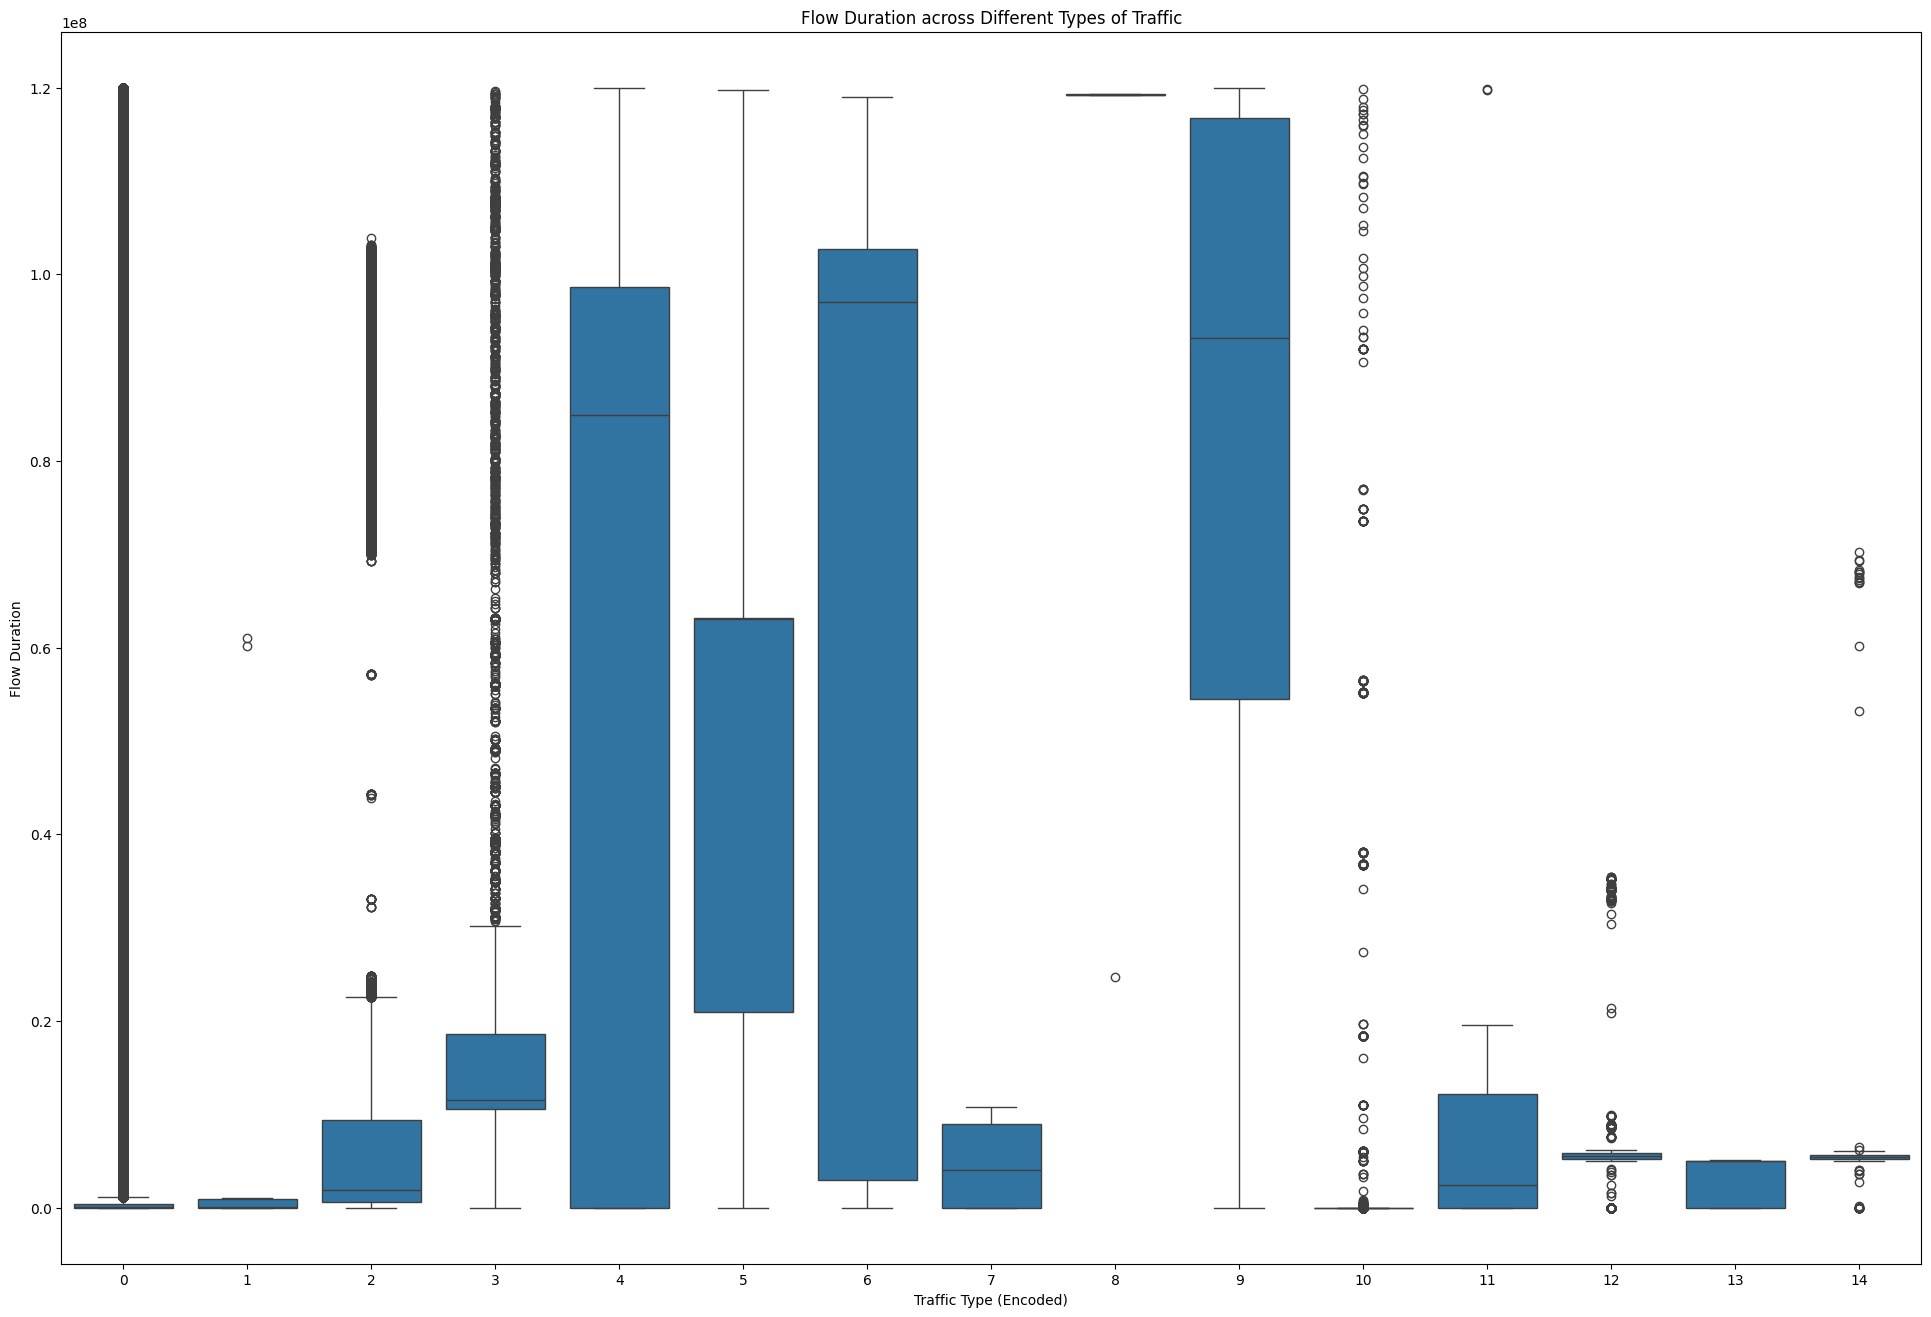

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the plot
plt.figure(figsize=(24, 16))  # Width, Height in inches

sns.boxplot(x='label_encoded', y='flow_duration', data=numeric_data)
plt.title('Flow Duration across Different Types of Traffic')
plt.xlabel('Traffic Type (Encoded)')
plt.ylabel('Flow Duration')
plt.show()

Here are some observations and potential insights based on the boxplot:

* Variability in Duration: There is significant variability in the duration of flows across different categories. Some types of attacks, like DoS and DDoS, have wider interquartile ranges (IQR), indicating more variability within these categories.

* Long Duration Attacks: The categories like DoS Hulk and Heartbleed show a larger range of flow durations, including some extremely high values, which could indicate prolonged attack activities.

* Short Duration Traffic: On the other hand, categories such as BENIGN, Infiltration, and various Web Attacks have shorter flow durations, as indicated by the lower median and IQR, which might be typical of regular traffic or more stealthy attacks.

* Outliers: There are numerous outliers in almost all categories, especially in DoS Hulk and DDoS. This could indicate the presence of exceptionally long flows that could be due to either malicious activities or non-malicious but unusual network behavior.

* Median and Mean Duration: Categories with higher medians like DoS GoldenEye might imply a consistently higher flow duration characteristic of the attack, while others with lower medians but high variability (like DDoS) might be sporadic or bursty.

* Potential for Feature Engineering: The flow duration, especially when considered in conjunction with other features like packet size and inter-arrival times, could be used to engineer additional features that more effectively discriminate between benign and malicious traffic.

From a data analysis and machine learning perspective, these insights suggest that flow_duration is a potentially useful feature for distinguishing between different types of traffic. Additionally, the presence of outliers and the variability within each category could be leveraged to identify thresholds or create features that help in the classification of traffic types.

## Handling Infinite Values

In [20]:
# Check for infinite values in the dataset
if np.any(np.isinf(numeric_data)):
    print("The dataset contains infinite values")

    # Check for infinite values
    infinite_ = numeric_data.columns.to_series()[np.isinf(numeric_data).any()]

    # Get unique feature names with infinite values from both train and test sets
    infinite_features = np.unique(infinite_.index.values)

    print("Features with infinite values:", infinite_features)

else:
    print("No infinite values in the dataset")

The dataset contains infinite values
Features with infinite values: ['flow_bytes/s' 'flow_packets/s']


In [21]:
# Iterate over each column in the DataFrame
for col in numeric_data.columns:
    # Check for infinite values in the current column
    infinite_values = np.isinf(numeric_data[col]).sum()
    
    # If there are infinite values, print the column name and the count
    if infinite_values > 0:
        print(f"Column '{col}' has {infinite_values} infinite values.")

Column 'flow_bytes/s' has 1509 infinite values.
Column 'flow_packets/s' has 2867 infinite values.


In [22]:
# Check for infinite values in each column
infinite_flow_bytes = np.isinf(all_data['flow_bytes/s']).sum()
infinite_flow_packets = np.isinf(all_data['flow_packets/s']).sum()

# Combine the results to find the total number of samples with infinite values in either column
total_infinite = infinite_flow_bytes + infinite_flow_packets

print(f"Number of samples with infinite values in 'flow_bytes/s': {infinite_flow_bytes}")
print(f"Number of samples with infinite values in 'flow_packets/s': {infinite_flow_packets}")
print(f"Total number of samples with infinite values in either column: {total_infinite}")

Number of samples with infinite values in 'flow_bytes/s': 1509
Number of samples with infinite values in 'flow_packets/s': 2867
Total number of samples with infinite values in either column: 4376


`flow_bytes/s` and `flow_packets/s` will prevent the models from running. These infinite values likely occur when the flow duration is 0, leading to division by zero when calculating the bytes/second and packets/second. 

Theory: When the flow duration is 0, these features become undefined (division by zero). This can happen in cases where there is only a single packet in the flow or when there are issues with the data collection process.

There are several ways to handle infinite values in these features:

* Set to 0: This is a simple approach, but it might not be the most accurate representation of the data. Setting these features to 0 implies that there was no data transmitted during the flow, which might not be true.

* Set to median/mean: Replacing infinite values with the median or mean of the respective feature can be a better option than setting them to 0. However, this approach can be sensitive to outliers and might not accurately represent the true distribution of the data.

* Drop samples: You could drop the samples with infinite values. However, this might lead to information loss, especially if a significant portion of your data contains these values.

* Further investigation: It is important to understand why these infinite values are occurring. Are they due to actual single-packet flows or data collection issues? Investigating the root cause can help you choose the most appropriate handling strategy.

Given that there are 2,830,743 samples in the dataset and only 4,376 samples have infinite values in either flow_bytes/s or flow_packets/s, dropping the samples with infinite values seems like a reasonable approach. The proportion of affected samples is relatively small (around 0.15%), so dropping them is unlikely to significantly impact the overall analysis or model training.

### Option 1: Set to Zero

In [95]:
# Replace infinite values with NaN
zeros_numeric_data = numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute NaN values with zero for 'flow_bytes/s' and 'flow_packets/s'
zeros_numeric_data.fillna({ 'flow_bytes/s': 0 }, inplace=True)
zeros_numeric_data.fillna({'flow_packets/s': 0}, inplace=True)


All infinite and NaN values have been handled


### Option 2: Set to Mean

In [24]:
# Calculate the mean of each column, excluding infinite values
mean_flow_bytes = numeric_data['flow_bytes/s'][~np.isinf(numeric_data['flow_bytes/s'])].mean()
mean_flow_packets = numeric_data['flow_packets/s'][~np.isinf(numeric_data['flow_packets/s'])].mean()

means_numeric_data = numeric_data

# Replace infinite values with the calculated means
means_numeric_data['flow_bytes/s'] = np.where(np.isinf(numeric_data['flow_bytes/s']), mean_flow_bytes, numeric_data['flow_bytes/s'])
means_numeric_data['flow_packets/s'] = np.where(np.isinf(numeric_data['flow_packets/s']), mean_flow_packets, numeric_data['flow_packets/s'])

### Verify Infinite Values

In [37]:
# Verify the replacement
if np.any(np.isinf(means_numeric_data)):
    print("The dataset still contains infinite or NaN values")
else:
    print("All infinite and NaN values have been handled")

All infinite and NaN values have been handled


## Feature Importance

The researchers do not explicitly explain how they calculated the weights in Table 3 of the paper. However, they do mention the use of `RandomForestRegressor`. Therefore, it is likely that they used a **feature importance technique**.

Here's how feature importance can be used to derive weights:

1. **Train a Random Forest model**: The researchers likely trained a Random Forest model on the entire dataset with all features and labels.

2. **Extract feature importances**: Random Forest models can provide a measure of how much each feature contributes to the model's predictions. This is often referred to as feature importance. There are different ways to calculate feature importance in Random Forests, such as mean decrease in impurity (MDI) or mean decrease in accuracy (MDA).

3. **Calculate weights**: The researchers might have used the feature importances directly as weights or applied some additional calculations or normalization to obtain the final weights shown in Table 3.

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have already loaded the data into 'reduced_numeric_data' DataFrame

# Separate features and labels
features = means_numeric_data.drop(['label_encoded'], axis=1)
labels = means_numeric_data['label_encoded']

# Create and train a RandomForestRegressor model
rf = RandomForestRegressor()
rf.fit(features, labels)

# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'feature': features.columns, 'importance': importances})

# Sort by importance in descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print the feature importances
print(feature_importances)

                        feature  importance
14                 flow_bytes/s    0.455488
4   total_length_of_fwd_packets    0.131653
13        bwd_packet_length_std    0.114935
63            subflow_fwd_bytes    0.103579
0              destination_port    0.058718
..                          ...         ...
58            fwd_avg_bulk_rate    0.000000
57         fwd_avg_packets/bulk    0.000000
50               ece_flag_count    0.000000
31                bwd_psh_flags    0.000000
56           fwd_avg_bytes/bulk    0.000000

[78 rows x 2 columns]


In [33]:
# Convert the feature importances DataFrame into a Markdown table
fi_table = feature_importances.to_markdown(index=False)

# Print the Markdown table
print(fi_table)

| feature                     |   importance |
|:----------------------------|-------------:|
| flow_bytes/s                |  0.455488    |
| total_length_of_fwd_packets |  0.131653    |
| bwd_packet_length_std       |  0.114935    |
| subflow_fwd_bytes           |  0.103579    |
| destination_port            |  0.0587184   |
| psh_flag_count              |  0.0188942   |
| bwd_packets/s               |  0.0145114   |
| flow_iat_mean               |  0.0131976   |
| init_win_bytes_forward      |  0.0128065   |
| fwd_iat_min                 |  0.0119197   |
| fwd_packet_length_std       |  0.0118704   |
| init_win_bytes_backward     |  0.00910936  |
| min_seg_size_forward        |  0.00603831  |
| average_packet_size         |  0.0053637   |
| fwd_header_length.1         |  0.00418433  |
| fwd_header_length           |  0.00409521  |
| idle_min                    |  0.00205257  |
| fwd_packet_length_max       |  0.0019659   |
| bwd_iat_mean                |  0.00195662  |
| subflow_bwd

Key Insights from Feature Importances:

Most Influential Features:
* flow_bytes/s stands out as the most important feature, suggesting that the rate of bytes over the flow duration is crucial for distinguishing between different classes of network traffic.
* total_length_of_fwd_packets, bwd_packet_length_std, and subflow_fwd_bytes are also highly important, indicating the significance of packet lengths and subflow characteristics.

Less Influential Features:
* Several features such as bwd_urg_flags, various bulk rate features, and fwd_avg_bytes/bulk have zero importance, implying they do not contribute to the model's decision-making process. This could be due to a lack of variability in these features or their irrelevance to the target variable.

Potential for Dimensionality Reduction:
* Given that some features have very low or zero importance, there's potential for dimensionality reduction to simplify the model without significantly impacting performance. This could improve model interpretability and computational efficiency.

Show the distribution of values for four heaviest parameters.

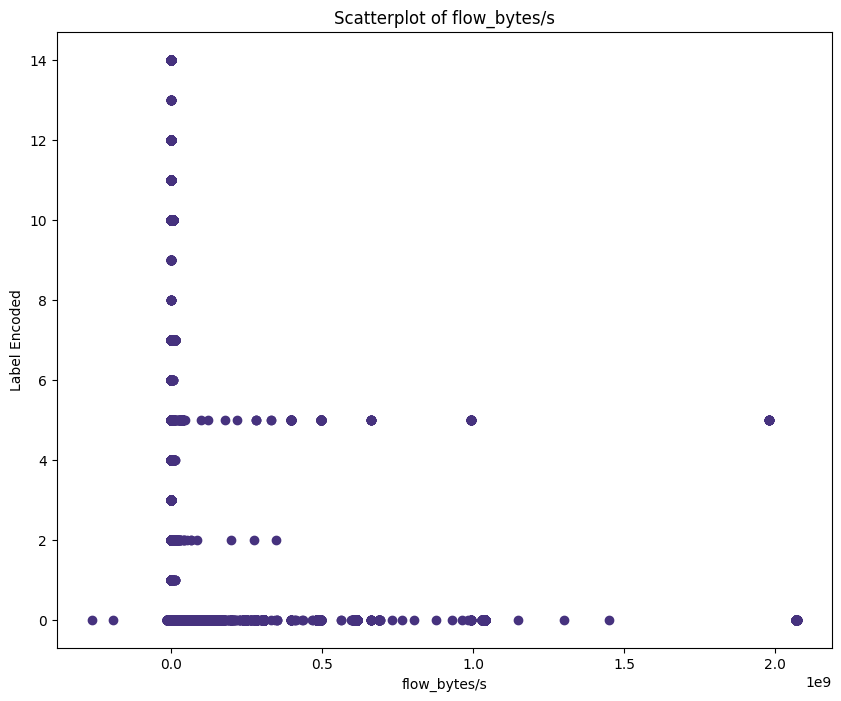

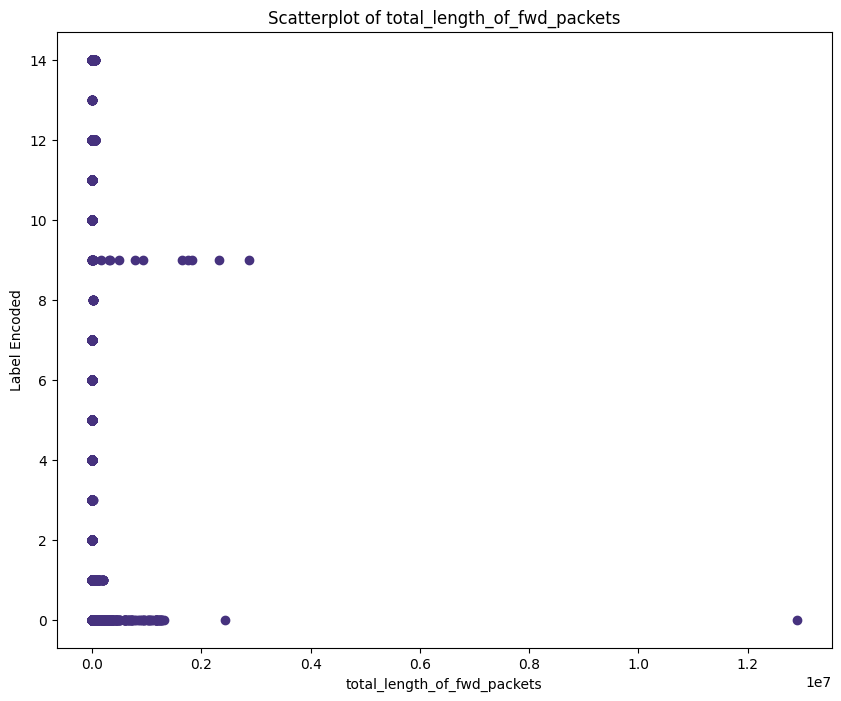

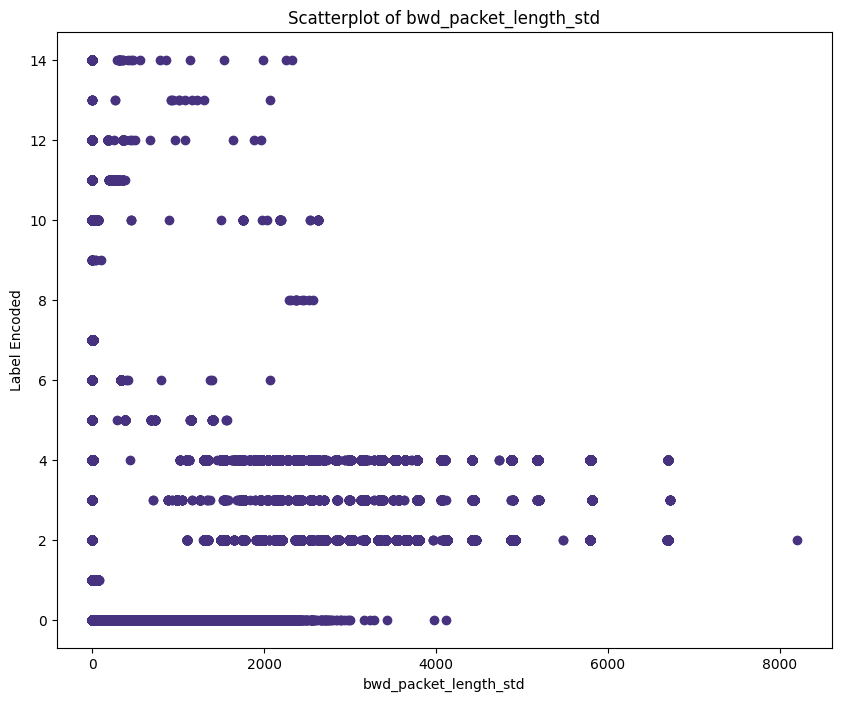

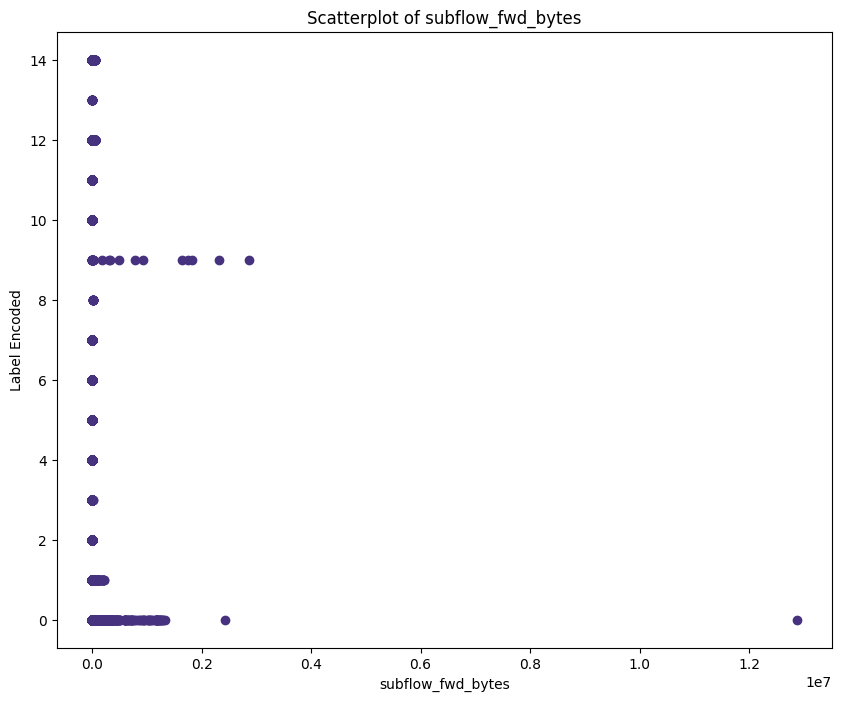

In [36]:
# Set the color palette to "viridis"
sns.set_palette("viridis")

# Get the names of the top 4 weighted features
top_features = feature_importances.head(4)['feature'].tolist()

# Extract the corresponding columns from means_numeric_data
top_features_data = means_numeric_data[top_features]

# Create four separate scatterplots for the top 4 features
for feature in top_features:
    plt.figure(figsize=(10, 8))
    plt.scatter(top_features_data[feature], means_numeric_data['label_encoded'])
    plt.xlabel(feature)
    plt.ylabel('Label Encoded')
    plt.title(f'Scatterplot of {feature}')
    plt.show()


# Baselines

Steps for baseline modeling:

1. Splitting: Split the data into training and test sets.
2. Feature scaling: Scale the feature for KNN because it is sensitive to the magnitude of the data.
3. Training: Train the models.
4. Evaluation: Determine the baseline performance.

In [39]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## KNN + RF

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split the data

X = numeric_data.drop(['label_encoded'], axis=1) # Features
y = numeric_data['label_encoded'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Feature scaling
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [81]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5) # TODO look into best way to fine-tune this hyperparameter
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [82]:
# RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [83]:
# Evaluate

# Evaluate KNN
y_pred_knn = knn.predict(X_test_scaled)
print('KNN Model Evaluation')
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

# Evaluate RF
y_pred_rf = rf.predict(X_test)
print('\nRandom Forest Model Evaluation')
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

KNN Model Evaluation


/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: Und

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    453911
           1       0.74      0.64      0.69       390
           2       1.00      1.00      1.00     25627
           3       0.98      0.99      0.99      2077
           4       1.00      1.00      1.00     46827
           5       0.98      0.99      0.98      1112
           6       0.99      0.99      0.99      1180
           7       1.00      1.00      1.00      1620
           8       1.00      1.00      1.00         1
           9       0.50      0.17      0.25         6
          10       0.95      0.98      0.97     31806
          11       0.96      0.99      0.98      1166
          12       0.71      0.74      0.72       293
          13       0.00      0.00      0.00         2
          14       0.42      0.31      0.36       131

    accuracy                           0.99    566149
   macro avg       0.82      0.79      0.79    566149
weighted avg       0.99   

/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    453911
           1       0.88      0.77      0.82       390
           2       1.00      1.00      1.00     25627
           3       1.00      1.00      1.00      2077
           4       1.00      1.00      1.00     46827
           5       0.99      0.99      0.99      1112
           6       0.99      0.99      0.99      1180
           7       1.00      1.00      1.00      1620
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         6
          10       0.99      1.00      0.99     31806
          11       1.00      1.00      1.00      1166
          12       0.72      0.83      0.77       293
          13       0.00      0.00      0.00         2
          14       0.41      0.24      0.31       131

    accuracy                           1.00    566149
   macro avg       0.87      0.85      0.86    566149
weighted avg       1.00   

/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## KNN

For K-Nearest Neighbors (KNN), it's crucial to scale the data because KNN calculates the distance between data points for its predictions, and features on larger scales can unduly influence the model.

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

# Correcting the dataset name to 'means_numeric_data'
X = means_numeric_data.drop(['label_encoded'], axis=1)  # Features
y = means_numeric_data['label_encoded']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first scales the data and then applies KNN
knn_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(), 
    KNeighborsClassifier(n_neighbors=5))

# Plot learning curve for KNN with n_neighbors=5
plot_learning_curve(knn_pipeline, "Learning Curve (KNN, n_neighbors=5)", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

python(95702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95706) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## Random Forest

In [28]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Correcting the dataset name to 'means_numeric_data'
X = means_numeric_data.drop(['label_encoded'], axis=1)  # Features
y = means_numeric_data['label_encoded']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 1 of 100
building tree 4 of 100
building tree 5 of 100
building tree 1 of 100
building tree 6 of 100
building tree 1 of 100
building tree 7 of 100
building tree 2 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 3 of 100
building tree 12 of 100
building tree 2 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 4 of 100
building tree 16 of 100
building tree 17 of 100
building tree 2 of 100
building tree 18 of 100
building tree 5 of 100
building tree 19 of 100
building tree 20 of 100
building tree 3 of 100
building tree 21 of 100
building tree 22 of 100
building tree 6 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 7 of 100
building tree 27 of 100
building tree 28 of 100
building tree 4 of 100
building tree 29 of 100
building tree 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.4s


building tree 41 of 100
building tree 6 of 100
building tree 42 of 100
building tree 11 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 12 of 100
building tree 47 of 100
building tree 48 of 100
building tree 7 of 100
building tree 49 of 100
building tree 50 of 100
building tree 13 of 100
building tree 5 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 14 of 100
building tree 55 of 100
building tree 8 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 15 of 100
building tree 59 of 100
building tree 60 of 100
building tree 6 of 100
building tree 61 of 100
building tree 62 of 100
building tree 16 of 100
building tree 9 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 17 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 16 of 100
building tree 29 of 100
building tree 11 of 100
building tree 30 of 100
building tree 17 of 100
building tree 31 of 100
building tree 12 of 100
building tree 32 of 100
building tree 1 of 100
building tree 18 of 100
building tree 33 of 100
building tree 34 of 100
building tree 19 of 100
building tree 13 of 100
building tree 35 of 100
building tree 2 of 100
building tree 36 of 100
building tree 20 of 100
building tree 37 of 100
building tree 14 of 100
building tree 21 of 100
building tree 38 of 100
building tree 39 of 100
building tree 3 of 100
building tree 22 of 100
building tree 40 of 100
building tree 15 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.4s


building tree 41 of 100
building tree 23 of 100
building tree 42 of 100
building tree 43 of 100
building tree 16 of 100
building tree 24 of 100
building tree 4 of 100
building tree 44 of 100
building tree 45 of 100
building tree 25 of 100
building tree 17 of 100
building tree 46 of 100
building tree 47 of 100
building tree 26 of 100
building tree 5 of 100
building tree 48 of 100
building tree 18 of 100
building tree 27 of 100
building tree 49 of 100
building tree 50 of 100
building tree 19 of 100
building tree 6 of 100
building tree 28 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 29 of 100
building tree 20 of 100
building tree 54 of 100
building tree 7 of 100
building tree 30 of 100
building tree 55 of 100
building tree 21 of 100
building tree 56 of 100
building tree 31 of 100
building tree 57 of 100
building tree 58 of 100
building tree 8 of 100
building tree 22 of 100
building tree 32 of 100
building tree 59 of 100
building tree 60 of 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 100
building tree 76 of 100
building tree 29 of 100
building tree 77 of 100
building tree 13 of 100
building tree 42 of 100
building tree 78 of 100
building tree 79 of 100
building tree 43 of 100
building tree 30 of 100
building tree 80 of 100
building tree 14 of 100
building tree 81 of 100
building tree 44 of 100
building tree 82 of 100
building tree 31 of 100
building tree 83 of 100
building tree 45 of 100
building tree 84 of 100
building tree 15 of 100
building tree 85 of 100
building tree 32 of 100
building tree 46 of 100
building tree 86 of 100
building tree 87 of 100
building tree 47 of 100
building tree 33 of 100
building tree 88 of 100
building tree 16 of 100
building tree 89 of 100
building tree 48 of 100
building tree 90 of 100
building tree 34 of 100
building tree 91 of 100
building tree 49 of 100
building tree 17 of 100
building tree 92 of 100
building tree 93 of 100
building tree 35 of 100
building tree 50 of 100
building tree 94 of 100
building tree 18

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 39 of 100
building tree 56 of 100
building tree 21 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


building tree 57 of 100
building tree 40 of 100
building tree 58 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 22 of 100
building tree 4 of 100
building tree 5 of 100
building tree 59 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.7min


building tree 41 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 60 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 23 of 100
building tree 42 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 61 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 43 of 100
building tree 28 of 100
building tree 62 of 100
building tree 29 of 100
building tree 30 of 100
building tree 24 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 63 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.2s


building tree 41 of 100
building tree 42 of 100
building tree 64 of 100
building tree 43 of 100
building tree 25 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 45 of 100
building tree 65 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 26 of 100
building tree 66 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 46 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 67 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 68 of 100
building tree 71 of 100
building tree 72 of 100
building tree 47

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 74 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 51 of 100
building tree 30 of 100
building tree 1 of 100
building tree 75 of 100
building tree 2 of 100
building tree 76 of 100
building tree 3 of 100
building tree 52 of 100
building tree 4 of 100
building tree 77 of 100
building tree 31 of 100
building tree 5 of 100
building tree 53 of 100
building tree 78 of 100
building tree 6 of 100
building tree 7 of 100
building tree 54 of 100
building tree 8 of 100
building tree 79 of 100
building tree 32 of 100
building tree 9 of 100
building tree 80 of 100
building tree 10 of 100
building tree 55 of 100
building tree 11 of 100
building tree 81 of 100
building tree 12 of 100
building tree 33 of 100
building tree 13 of 100
building tree 56 of 100
building tree 82 of 100
building tree 14 of 100
building tree 15 of 100
building tree 83 of 100
building tree 57 of 100
building tree 34 of 100
building tree 16 of 100
building tree 84 of 100
building tree 17 of 100
building tree 58 of 100
building tree 18 of 100
building tree 85 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.4min


building tree 41 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.7s


building tree 41 of 100
building tree 98 of 100
building tree 67 of 100
building tree 42 of 100
building tree 43 of 100
building tree 99 of 100
building tree 42 of 100
building tree 44 of 100
building tree 68 of 100
building tree 100 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 69 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 70 of 100
building tree 51 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.1s


building tree 44 of 100
building tree 52 of 100
building tree 71 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 1 of 100
building tree 45 of 100
building tree 72 of 100
building tree 56 of 100
building tree 57 of 100
building tree 2 of 100
building tree 58 of 100
building tree 73 of 100
building tree 59 of 100
building tree 3 of 100
building tree 46 of 100
building tree 60 of 100
building tree 61 of 100
building tree 74 of 100
building tree 4 of 100
building tree 62 of 100
building tree 63 of 100
building tree 5 of 100
building tree 47 of 100
building tree 75 of 100
building tree 64 of 100
building tree 6 of 100
building tree 65 of 100
building tree 76 of 100
building tree 66 of 100
building tree 7 of 100
building tree 48 of 100
building tree 67 of 100
building tree 68 of 100
building tree 8 of 100
building tree 77 of 100
building tree 69 of 100
building tree 9 of 100
building tree 70 of 100
building tree 78 of 100
building tree 49 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 27 of 100
building tree 58 of 100
building tree 90 of 100
building tree 28 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


building tree 29 of 100
building tree 59 of 100
building tree 91 of 100
building tree 30 of 100
building tree 1 of 100
building tree 92 of 100
building tree 31 of 100
building tree 60 of 100
building tree 2 of 100
building tree 32 of 100
building tree 93 of 100
building tree 33 of 100
building tree 61 of 100
building tree 3 of 100
building tree 94 of 100
building tree 34 of 100
building tree 95 of 100
building tree 4 of 100
building tree 35 of 100
building tree 62 of 100
building tree 36 of 100
building tree 5 of 100
building tree 96 of 100
building tree 63 of 100
building tree 37 of 100
building tree 6 of 100
building tree 97 of 100
building tree 38 of 100
building tree 39 of 100
building tree 7 of 100
building tree 64 of 100
building tree 98 of 100
building tree 40 of 100
building tree 8 of 100
building tree 99 of 100
building tree 41 of 100
building tree 65 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 42 of 100
building tree 9 of 100
building tree 100 of 100
building tree 43 of 100
building tree 66 of 100
building tree 10 of 100
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


building tree 45 of 100
building tree 11 of 100
building tree 67 of 100
building tree 46 of 100
building tree 12 of 100
building tree 68 of 100
building tree 47 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s


building tree 48 of 100
building tree 13 of 100
building tree 69 of 100
building tree 49 of 100
building tree 14 of 100
building tree 50 of 100
building tree 70 of 100
building tree 51 of 100
building tree 15 of 100
building tree 1 of 100
building tree 52 of 100
building tree 16 of 100
building tree 53 of 100
building tree 71 of 100
building tree 2 of 100
building tree 54 of 100
building tree 17 of 100
building tree 55 of 100
building tree 72 of 100
building tree 3 of 100
building tree 18 of 100
building tree 56 of 100
building tree 57 of 100
building tree 19 of 100
building tree 73 of 100
building tree 58 of 100
building tree 4 of 100
building tree 20 of 100
building tree 59 of 100
building tree 74 of 100
building tree 21 of 100
building tree 5 of 100
building tree 60 of 100
building tree 61 of 100
building tree 75 of 100
building tree 22 of 100
building tree 6 of 100
building tree 62 of 100
building tree 23 of 100
building tree 63 of 100
building tree 76 of 100
building tree 7 of 100

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


building tree 41 of 100
building tree 90 of 100
building tree 20 of 100
building tree 90 of 100
building tree 91 of 100
building tree 42 of 100
building tree 92 of 100
building tree 91 of 100
building tree 21 of 100
building tree 43 of 100
building tree 93 of 100
building tree 94 of 100
building tree 92 of 100
building tree 22 of 100
building tree 44 of 100
building tree 95 of 100
building tree 45 of 100
building tree 23 of 100
building tree 93 of 100
building tree 96 of 100
building tree 97 of 100
building tree 46 of 100
building tree 94 of 100
building tree 24 of 100
building tree 98 of 100
building tree 47 of 100
building tree 99 of 100
building tree 95 of 100
building tree 25 of 100
building tree 100 of 100
building tree 48 of 100
building tree 96 of 100
building tree 26 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 49 of 100
building tree 97 of 100
building tree 50 of 100
building tree 27 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.3s


building tree 51 of 100
building tree 28 of 100
building tree 98 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 52 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 29 of 100
building tree 99 of 100
building tree 13 of 100
building tree 14 of 100
building tree 53 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 54 of 100
building tree 30 of 100
building tree 26 of 100
building tree 27 of 100
building tree 100 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.3s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 56 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 32 of 100
building tree 54 of 100
building tree 55 of 100
building tree 57 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 58 of 100
building tree 66 of 100
building tree 33 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.9s


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 59 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 34 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 60 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 1 of 100
building tree 96 of 100
building tree 61 of 100
building tree 97 of 100
building tree 98 of 100
building tree 35 of 100
building tree 99 of 100
building tree 2 of 100
building tree 100 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s


building tree 62 of 100
building tree 4 of 100
building tree 5 of 100
building tree 36 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 6 of 100


/Users/seansica/Library/CloudStorage/OneDrive-Sica/Education/Berkeley/W207-Applied-ML/final_project/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


building tree 63 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 37 of 100
building tree 1 of 100
building tree 64 of 100
building tree 10 of 100
building tree 11 of 100
building tree 2 of 100
building tree 12 of 100
building tree 65 of 100
building tree 38 of 100
building tree 3 of 100
building tree 13 of 100
building tree 14 of 100
building tree 66 of 100
building tree 15 of 100
building tree 4 of 100
building tree 39 of 100
building tree 16 of 100
building tree 5 of 100
building tree 17 of 100
building tree 67 of 100
building tree 18 of 100
building tree 6 of 100
building tree 19 of 100
building tree 40 of 100
building tree 20 of 100
building tree 7 of 100
building tree 68 of 100
building tree 21 of 100
building tree 22 of 100
building tree 8 of 100
building tree 23 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.6min


building tree 41 of 100
building tree 69 of 100
building tree 24 of 100
building tree 9 of 100
building tree 25 of 100
building tree 10 of 100
building tree 70 of 100
building tree 26 of 100
building tree 42 of 100
building tree 27 of 100
building tree 11 of 100
building tree 28 of 100
building tree 71 of 100
building tree 29 of 100
building tree 12 of 100
building tree 30 of 100
building tree 43 of 100
building tree 13 of 100
building tree 72 of 100
building tree 31 of 100
building tree 32 of 100
building tree 14 of 100
building tree 33 of 100
building tree 73 of 100
building tree 44 of 100
building tree 34 of 100
building tree 15 of 100
building tree 35 of 100
building tree 74 of 100
building tree 16 of 100
building tree 36 of 100
building tree 37 of 100
building tree 45 of 100
building tree 17 of 100
building tree 38 of 100
building tree 75 of 100
building tree 39 of 100
building tree 18 of 100
building tree 40 of 100
building tree 76 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   44.2s


building tree 41 of 100
building tree 19 of 100
building tree 46 of 100
building tree 42 of 100
building tree 43 of 100
building tree 20 of 100
building tree 77 of 100
building tree 44 of 100
building tree 21 of 100
building tree 45 of 100
building tree 47 of 100
building tree 46 of 100
building tree 78 of 100
building tree 22 of 100
building tree 47 of 100
building tree 48 of 100
building tree 23 of 100
building tree 79 of 100
building tree 49 of 100
building tree 48 of 100
building tree 50 of 100
building tree 24 of 100
building tree 51 of 100
building tree 80 of 100
building tree 25 of 100
building tree 52 of 100
building tree 53 of 100
building tree 49 of 100
building tree 26 of 100
building tree 54 of 100
building tree 81 of 100
building tree 55 of 100
building tree 27 of 100
building tree 56 of 100
building tree 82 of 100
building tree 57 of 100
building tree 28 of 100
building tree 50 of 100
building tree 58 of 100
building tree 29 of 100
building tree 59 of 100
building tree 83

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 82 of 100
building tree 83 of 100
building tree 42 of 100
building tree 92 of 100
building tree 84 of 100
building tree 58 of 100
building tree 85 of 100
building tree 43 of 100
building tree 86 of 100
building tree 93 of 100
building tree 87 of 100
building tree 44 of 100
building tree 88 of 100
building tree 59 of 100
building tree 94 of 100
building tree 45 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 46 of 100
building tree 95 of 100
building tree 92 of 100
building tree 47 of 100
building tree 93 of 100
building tree 60 of 100
building tree 96 of 100
building tree 94 of 100
building tree 48 of 100
building tree 95 of 100
building tree 96 of 100
building tree 61 of 100
building tree 97 of 100
building tree 49 of 100
building tree 97 of 100
building tree 98 of 100
building tree 50 of 100
building tree 99 of 100
building tree 98 of 100
building tree 100 of 100
building tree 62 of 100
building tree 51 of 100
building tree 9

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 52 of 100
building tree 63 of 100
building tree 53 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s


building tree 100 of 100
building tree 54 of 100
building tree 64 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


building tree 1 of 100
building tree 56 of 100
building tree 57 of 100
building tree 65 of 100
building tree 2 of 100
building tree 58 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.5s


building tree 59 of 100
building tree 3 of 100
building tree 66 of 100
building tree 60 of 100
building tree 4 of 100
building tree 61 of 100
building tree 67 of 100
building tree 62 of 100
building tree 5 of 100
building tree 1 of 100
building tree 68 of 100
building tree 63 of 100
building tree 6 of 100
building tree 64 of 100
building tree 2 of 100
building tree 69 of 100
building tree 65 of 100
building tree 7 of 100
building tree 66 of 100
building tree 8 of 100
building tree 70 of 100
building tree 67 of 100
building tree 3 of 100
building tree 9 of 100
building tree 68 of 100
building tree 71 of 100
building tree 69 of 100
building tree 4 of 100
building tree 10 of 100
building tree 70 of 100
building tree 72 of 100
building tree 11 of 100
building tree 71 of 100
building tree 5 of 100
building tree 72 of 100
building tree 12 of 100
building tree 73 of 100
building tree 73 of 100
building tree 6 of 100
building tree 13 of 100
building tree 74 of 100
building tree 74 of 100
build

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 32 of 100
building tree 88 of 100
building tree 21 of 100
building tree 33 of 100
building tree 89 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.2s


building tree 34 of 100
building tree 22 of 100
building tree 90 of 100
building tree 1 of 100
building tree 2 of 100
building tree 35 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 23 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 36 of 100
building tree 91 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 24 of 100
building tree 23 of 100
building tree 24 of 100
building tree 37 of 100
building tree 25 of 100
building tree 26 of 100
building tree 92 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   11.9s


building tree 42 of 100
building tree 43 of 100
building tree 39 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 26 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 94 of 100
building tree 53 of 100
building tree 40 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 27 of 100
building tree 64 of 100
building tree 65 of 100
building tree 41 of 100
building tree 95 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 42 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 28 of 100
building tree 80 of 100
building tree 96 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 43 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 29 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 97 of 100
building tree 44 of 100
building tree 98 of 100
building tree 99 of 100
building tree 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 30 of 100
building tree 45 of 100
building tree 98 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 46 of 100
building tree 31 of 100
building tree 99 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 47 of 100
building tree 32 of 100
building tree 4 of 100
building tree 100 of 100
building tree 5 of 100
building tree 6 of 100
building tree 48 of 100
building tree 7 of 100
building tree 33 of 100
building tree 8 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


building tree 49 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 50 of 100
building tree 34 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 51 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.4s


building tree 15 of 100
building tree 35 of 100
building tree 16 of 100
building tree 17 of 100
building tree 52 of 100
building tree 18 of 100
building tree 36 of 100
building tree 19 of 100
building tree 20 of 100
building tree 53 of 100
building tree 21 of 100
building tree 22 of 100
building tree 54 of 100
building tree 37 of 100
building tree 23 of 100
building tree 1 of 100
building tree 24 of 100
building tree 25 of 100
building tree 55 of 100
building tree 2 of 100
building tree 26 of 100
building tree 38 of 100
building tree 27 of 100
building tree 3 of 100
building tree 56 of 100
building tree 28 of 100
building tree 29 of 100
building tree 4 of 100
building tree 39 of 100
building tree 30 of 100
building tree 57 of 100
building tree 31 of 100
building tree 5 of 100
building tree 32 of 100
building tree 58 of 100
building tree 6 of 100
building tree 33 of 100
building tree 40 of 100
building tree 34 of 100
building tree 7 of 100
building tree 59 of 100
building tree 35 of 100

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.6min


building tree 8 of 100
building tree 37 of 100
building tree 60 of 100
building tree 38 of 100
building tree 9 of 100
building tree 39 of 100
building tree 42 of 100
building tree 10 of 100
building tree 40 of 100
building tree 61 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   45.0s


building tree 41 of 100
building tree 11 of 100
building tree 42 of 100
building tree 62 of 100
building tree 43 of 100
building tree 12 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 13 of 100
building tree 63 of 100
building tree 46 of 100
building tree 47 of 100
building tree 14 of 100
building tree 44 of 100
building tree 48 of 100
building tree 64 of 100
building tree 49 of 100
building tree 15 of 100
building tree 50 of 100
building tree 65 of 100
building tree 51 of 100
building tree 16 of 100
building tree 45 of 100
building tree 52 of 100
building tree 66 of 100
building tree 53 of 100
building tree 17 of 100
building tree 54 of 100
building tree 18 of 100
building tree 55 of 100
building tree 46 of 100
building tree 67 of 100
building tree 56 of 100
building tree 19 of 100
building tree 57 of 100
building tree 58 of 100
building tree 68 of 100
building tree 20 of 100
building tree 47 of 100
building tree 59 of 100
building tree 21

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.3min


building tree 41 of 100
building tree 82 of 100
building tree 97 of 100
building tree 98 of 100
building tree 58 of 100
building tree 42 of 100
building tree 99 of 100
building tree 83 of 100
building tree 100 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 59 of 100
building tree 44 of 100
building tree 84 of 100
building tree 45 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s


building tree 85 of 100
building tree 60 of 100
building tree 46 of 100
building tree 86 of 100
building tree 47 of 100
building tree 61 of 100
building tree 48 of 100
building tree 1 of 100
building tree 87 of 100
building tree 49 of 100
building tree 62 of 100
building tree 2 of 100
building tree 88 of 100
building tree 50 of 100
building tree 51 of 100
building tree 89 of 100
building tree 63 of 100
building tree 3 of 100
building tree 52 of 100
building tree 90 of 100
building tree 4 of 100
building tree 53 of 100
building tree 64 of 100
building tree 54 of 100
building tree 91 of 100
building tree 5 of 100
building tree 55 of 100
building tree 92 of 100
building tree 65 of 100
building tree 6 of 100
building tree 56 of 100
building tree 57 of 100
building tree 93 of 100
building tree 7 of 100
building tree 66 of 100
building tree 58 of 100
building tree 94 of 100
building tree 59 of 100
building tree 8 of 100
building tree 67 of 100
building tree 95 of 100
building tree 60 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 72 of 100
building tree 70 of 100
building tree 16 of 100
building tree 71 of 100
building tree 73 of 100
building tree 72 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.5s


building tree 73 of 100
building tree 74 of 100
building tree 18 of 100
building tree 74 of 100
building tree 75 of 100
building tree 19 of 100
building tree 75 of 100
building tree 76 of 100
building tree 20 of 100
building tree 77 of 100
building tree 76 of 100
building tree 1 of 100
building tree 78 of 100
building tree 21 of 100
building tree 79 of 100
building tree 77 of 100
building tree 22 of 100
building tree 2 of 100
building tree 80 of 100
building tree 23 of 100
building tree 81 of 100
building tree 78 of 100
building tree 3 of 100
building tree 82 of 100
building tree 24 of 100
building tree 83 of 100
building tree 79 of 100
building tree 4 of 100
building tree 25 of 100
building tree 84 of 100
building tree 85 of 100
building tree 26 of 100
building tree 80 of 100
building tree 5 of 100
building tree 86 of 100
building tree 27 of 100
building tree 87 of 100
building tree 81 of 100
building tree 6 of 100
building tree 88 of 100
building tree 28 of 100
building tree 89 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 88 of 100
building tree 13 of 100
building tree 37 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.3s


building tree 89 of 100
building tree 38 of 100
building tree 14 of 100
building tree 39 of 100
building tree 1 of 100
building tree 2 of 100
building tree 90 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 15 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 40 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 91 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 16 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


building tree 41 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 92 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 42 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 17 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.1s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 93 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 18 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 44 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 94 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 19 of 100
building tree 63 of 100
building tree 45 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 95 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 46

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 49 of 100
building tree 98 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 23 of 100
building tree 50 of 100
building tree 1 of 100
building tree 2 of 100
building tree 99 of 100
building tree 51 of 100
building tree 24 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 52 of 100
building tree 100 of 100
building tree 6 of 100
building tree 25 of 100
building tree 7 of 100
building tree 8 of 100
building tree 53 of 100
building tree 9 of 100
building tree 26 of 100
building tree 10 of 100
building tree 54 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 11 of 100
building tree 12 of 100
building tree 27 of 100
building tree 13 of 100
building tree 55 of 100
building tree 14 of 100
building tree 15 of 100
building tree 56 of 100
building tree 16 of 100
building tree 28 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.1s


building tree 18 of 100
building tree 57 of 100
building tree 19 of 100
building tree 20 of 100
building tree 29 of 100
building tree 21 of 100
building tree 58 of 100
building tree 22 of 100
building tree 23 of 100
building tree 59 of 100
building tree 30 of 100
building tree 24 of 100
building tree 25 of 100
building tree 1 of 100
building tree 26 of 100
building tree 2 of 100
building tree 60 of 100
building tree 27 of 100
building tree 31 of 100
building tree 28 of 100
building tree 3 of 100
building tree 61 of 100
building tree 29 of 100
building tree 30 of 100
building tree 4 of 100
building tree 32 of 100
building tree 31 of 100
building tree 62 of 100
building tree 32 of 100
building tree 5 of 100
building tree 33 of 100
building tree 6 of 100
building tree 63 of 100
building tree 34 of 100
building tree 33 of 100
building tree 35 of 100
building tree 7 of 100
building tree 36 of 100
building tree 64 of 100
building tree 37 of 100
building tree 8 of 100
building tree 38 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   42.5s


building tree 35 of 100
building tree 42 of 100
building tree 66 of 100
building tree 11 of 100
building tree 43 of 100
building tree 44 of 100
building tree 12 of 100
building tree 45 of 100
building tree 67 of 100
building tree 36 of 100
building tree 46 of 100
building tree 13 of 100
building tree 47 of 100
building tree 68 of 100
building tree 48 of 100
building tree 14 of 100
building tree 37 of 100
building tree 49 of 100
building tree 15 of 100
building tree 50 of 100
building tree 69 of 100
building tree 51 of 100
building tree 52 of 100
building tree 16 of 100
building tree 38 of 100
building tree 53 of 100
building tree 70 of 100
building tree 54 of 100
building tree 17 of 100
building tree 55 of 100
building tree 18 of 100
building tree 56 of 100
building tree 39 of 100
building tree 71 of 100
building tree 57 of 100
building tree 19 of 100
building tree 58 of 100
building tree 72 of 100
building tree 59 of 100
building tree 20 of 100
building tree 40 of 100
building tree 60

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.5min


building tree 41 of 100
building tree 74 of 100
building tree 64 of 100
building tree 23 of 100
building tree 65 of 100
building tree 66 of 100
building tree 24 of 100
building tree 42 of 100
building tree 75 of 100
building tree 67 of 100
building tree 25 of 100
building tree 68 of 100
building tree 76 of 100
building tree 69 of 100
building tree 43 of 100
building tree 26 of 100
building tree 70 of 100
building tree 71 of 100
building tree 77 of 100
building tree 27 of 100
building tree 72 of 100
building tree 73 of 100
building tree 44 of 100
building tree 28 of 100
building tree 74 of 100
building tree 78 of 100
building tree 75 of 100
building tree 29 of 100
building tree 76 of 100
building tree 77 of 100
building tree 30 of 100
building tree 45 of 100
building tree 79 of 100
building tree 78 of 100
building tree 79 of 100
building tree 31 of 100
building tree 80 of 100
building tree 81 of 100
building tree 80 of 100
building tree 32 of 100
building tree 46 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.3min


building tree 99 of 100
building tree 51 of 100
building tree 87 of 100
building tree 42 of 100
building tree 100 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 88 of 100
building tree 52 of 100
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


building tree 89 of 100
building tree 45 of 100
building tree 53 of 100
building tree 46 of 100
building tree 90 of 100
building tree 1 of 100
building tree 47 of 100
building tree 91 of 100
building tree 54 of 100
building tree 48 of 100
building tree 2 of 100
building tree 92 of 100
building tree 55 of 100
building tree 49 of 100
building tree 3 of 100
building tree 50 of 100
building tree 93 of 100
building tree 56 of 100
building tree 51 of 100
building tree 4 of 100
building tree 94 of 100
building tree 52 of 100
building tree 5 of 100
building tree 57 of 100
building tree 95 of 100
building tree 53 of 100
building tree 54 of 100
building tree 6 of 100
building tree 96 of 100
building tree 58 of 100
building tree 55 of 100
building tree 7 of 100
building tree 56 of 100
building tree 97 of 100
building tree 59 of 100
building tree 57 of 100
building tree 8 of 100
building tree 98 of 100
building tree 58 of 100
building tree 9 of 100
building tree 60 of 100
building tree 59 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 62 of 100
building tree 63 of 100
building tree 12 of 100
building tree 64 of 100
building tree 13 of 100
building tree 63 of 100
building tree 65 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s


building tree 66 of 100
building tree 14 of 100
building tree 64 of 100
building tree 67 of 100
building tree 68 of 100
building tree 15 of 100
building tree 69 of 100
building tree 65 of 100
building tree 16 of 100
building tree 70 of 100
building tree 1 of 100
building tree 17 of 100
building tree 66 of 100
building tree 71 of 100
building tree 72 of 100
building tree 18 of 100
building tree 2 of 100
building tree 67 of 100
building tree 73 of 100
building tree 19 of 100
building tree 74 of 100
building tree 3 of 100
building tree 68 of 100
building tree 75 of 100
building tree 20 of 100
building tree 76 of 100
building tree 21 of 100
building tree 4 of 100
building tree 69 of 100
building tree 77 of 100
building tree 78 of 100
building tree 22 of 100
building tree 5 of 100
building tree 79 of 100
building tree 70 of 100
building tree 23 of 100
building tree 80 of 100
building tree 6 of 100
building tree 24 of 100
building tree 81 of 100
building tree 71 of 100
building tree 82 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 82 of 100
building tree 38 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.0s


building tree 39 of 100
building tree 83 of 100
building tree 40 of 100
building tree 18 of 100
building tree 84 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


building tree 41 of 100
building tree 19 of 100
building tree 85 of 100
building tree 42 of 100
building tree 20 of 100
building tree 43 of 100
building tree 86 of 100
building tree 21 of 100
building tree 44 of 100
building tree 87 of 100
building tree 45 of 100
building tree 22 of 100
building tree 46 of 100
building tree 88 of 100
building tree 23 of 100
building tree 47 of 100
building tree 89 of 100
building tree 24 of 100
building tree 48 of 100
building tree 90 of 100
building tree 49 of 100
building tree 25 of 100
building tree 91 of 100
building tree 50 of 100
building tree 26 of 100
building tree 92 of 100
building tree 51 of 100
building tree 27 of 100
building tree 52 of 100
building tree 93 of 100
building tree 53 of 100
building tree 28 of 100
building tree 94 of 100
building tree 54 of 100
building tree 29 of 100
building tree 55 of 100
building tree 95 of 100
building tree 56 of 100
building tree 30 of 100
building tree 96 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 64 of 100
building tree 36 of 100
building tree 65 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.2s


building tree 37 of 100
building tree 66 of 100
building tree 67 of 100
building tree 38 of 100
building tree 68 of 100
building tree 39 of 100
building tree 69 of 100
building tree 40 of 100
building tree 70 of 100
building tree 71 of 100
building tree 41 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.5min


building tree 72 of 100
building tree 42 of 100
building tree 73 of 100
building tree 43 of 100
building tree 74 of 100
building tree 44 of 100
building tree 75 of 100
building tree 76 of 100
building tree 45 of 100
building tree 77 of 100
building tree 46 of 100
building tree 78 of 100
building tree 79 of 100
building tree 47 of 100
building tree 80 of 100
building tree 48 of 100
building tree 81 of 100
building tree 49 of 100
building tree 82 of 100
building tree 83 of 100
building tree 50 of 100
building tree 84 of 100
building tree 51 of 100
building tree 85 of 100
building tree 52 of 100
building tree 86 of 100
building tree 87 of 100
building tree 53 of 100
building tree 88 of 100
building tree 54 of 100
building tree 89 of 100
building tree 55 of 100
building tree 90 of 100
building tree 91 of 100
building tree 56 of 100
building tree 92 of 100
building tree 57 of 100
building tree 93 of 100
building tree 58 of 100
building tree 94 of 100
building tree 59 of 100
building tree 95

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.9s


building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.4s


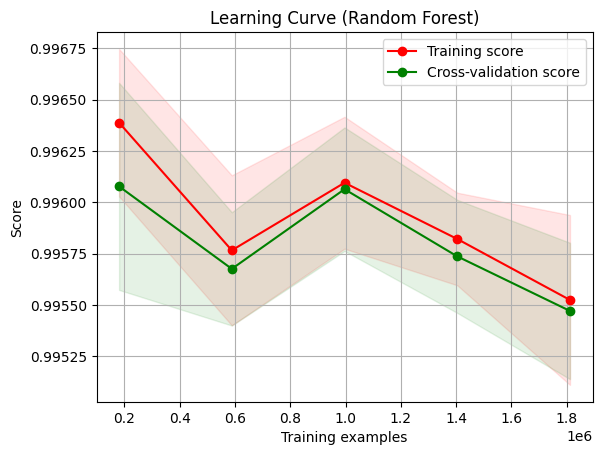

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Plotting the learning curve for RandomForestClassifier
plot_learning_curve(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, verbose=2),
                    "Learning Curve (Random Forest)", X_train, y_train, cv=5, n_jobs=4)
plt.show()

## Logistic Regression

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Create a pipeline that first imputes the data then applies Logistic Regression
pipeline = make_pipeline(imputer, LogisticRegression(max_iter=1000, random_state=42))

# Use the function to plot learning curve with the pipeline
plot_learning_curve(pipeline, "Learning Curve (Logistic Regression, with Imputation)", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC

# Due to SVM's computational complexity, consider using a subset of data or adjusting parameters for quicker execution
X_small, y_small = X_train[:10000], y_train[:10000]  # Adjust based on your machine's capability

# Plot learning curve for SVM
plot_learning_curve(SVC(kernel='linear', random_state=42),
                    "Learning Curve (SVM)", X_small, y_small, cv=5, n_jobs=-1)
plt.show()

## Sequential Backward Selection (SBS)

In [38]:
from sklearn.base import clone 
from itertools import combinations
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split

class SBS():

    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring 
        self.estimator = clone(estimator) 
        self.k_features = k_features 
        self.test_size = test_size 
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [41]:
# Count the number of NaN values in each feature
nan_counts = means_numeric_data.isna().sum()

# Get the features with NaN values
features_with_nan = nan_counts[nan_counts > 0].index.tolist()

# Print the number of NaN values and the features containing them
print("Number of NaN values:", nan_counts[features_with_nan])
print("Features with NaN values:", features_with_nan)


Number of NaN values: flow_bytes/s    1358
dtype: int64
Features with NaN values: ['flow_bytes/s']


In [42]:
from sklearn.impute import SimpleImputer
# Create an imputer object with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data
imputer.fit(X_train_scaled)

# Transform the NaN values in the training and test data to mean values
X_train_scaled_imputed = imputer.transform(X_train_scaled)
X_test_scaled_imputed = imputer.transform(X_test_scaled)



In [43]:
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)

# Use the imputed data for SBS
sbs.fit(X_train_scaled_imputed, y_train)

: 